In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
cd ..

C:\Users\Sommer Lab\Documents\Analysis Code


In [2]:
import sys
# sys.path.append(r'C:\Users\Sommer Lab\Documents\Analysis Code')
import os
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from scipy.integrate import simpson

from ImageAnalysis import ImageAnalysisCode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy import constants


In [3]:
fname = r'D:\Dropbox (Lehigh University)\Sommer Lab Shared\Data\2024\04-2024\22 Apr 2024\Vary EvapTime and Tau.csv'

In [4]:
df = pd.read_csv(fname)
df.head()

,Unnamed: 0,IterationNum,IterationCount,wait,AndorROIheight,AndorShortExpDelay_us,LFImg,LF_AOM_freq,time_compress,MOT_Re_Attn_final_V,...,eta,etaPrime,amplitude_xfit,amplitude_yfit,AtomNumber_yfit,center_x,center_y,width_x,width_y,Number_of_atoms
0,0,0.0,144.0,0.0,512.0,2415.44,3.598,226.0,5.0,2.5,...,10.0,10.833333,2.878320e+14,6.586970e+14,114274.625439,1065.115536,977.883661,128.711558,69.210846,-1.020138e+06
1,1,1.0,144.0,0.0,512.0,2415.44,3.598,226.0,5.0,2.5,...,10.0,10.833333,2.647315e+14,4.530477e+15,88056.843509,1045.132292,968.838558,97.125084,7.754061,-2.119811e+06
2,2,2.0,144.0,0.0,512.0,2415.44,3.598,226.0,5.0,2.5,...,10.0,10.833333,2.778593e+14,8.066411e+14,98714.684534,1055.872500,972.056635,97.640899,48.821542,1.325627e+07
3,3,3.0,144.0,0.0,512.0,2415.44,3.598,226.0,5.0,2.5,...,10.0,10.833333,2.001406e+14,1.295685e+15,81944.527146,1040.613878,969.878752,104.375389,25.230770,7.800418e+06
4,4,4.0,144.0,0.0,512.0,2415.44,3.598,226.0,5.0,2.5,...,10.0,10.833333,4.426643e+14,6.636713e+14,311693.831473,1027.552924,978.614423,212.650392,187.363595,-1.041941e+06


In [36]:
def multiVariableThermometry(df, *variables, fitXVar='TOF', fitYVar='width_y',
                             atomNum='AtomNumber_yfit', sigma1='width_x', sigma2='width_y', sigma3='width_y',
                             do_plot=1):
    params = ImageAnalysisCode.ExperimentParams( t_exp = 10e-6, picturesPerIteration= 4, cam_type = "zyla")
    
    dfmean = df.groupby(list(variables) + [fitXVar]).mean()
    df1 = dfmean[fitYVar].unstack()    

    if do_plot:
        indices = list(zip(*df1.index))
        runNo = np.prod( [len(np.unique(i)) for i in indices] )
        rowNo = int(runNo**0.5 / 1.1)
        if rowNo == 0:
            rowNo = 1
        colNo = int(np.ceil(runNo / rowNo))
        fig, axes = plt.subplots(rowNo, colNo, layout='constrained', squeeze = False,
                                 sharex=True, sharey=True)
        axes = axes.flatten()
        
    T = []
    
    for ii, (ind, item) in enumerate( df.groupby(list(variables)) ):
        
        ax = axes[ii] if do_plot else None
        _,_,_,popt,_= ImageAnalysisCode.temperature_fit(params, 
                                                        item[fitYVar]*1e-6, item[fitXVar]*1e-3, 
                                                        do_plot=1, ax=ax)
        
        if do_plot:
            ax.text(0, 20, '{} = '.format(variables) + str(ind), ha='left', va='bottom')
            # ax.text(0, 20, 'T (uK): {:.3f}'.format(popt[1]*1e6), ha='left', va='top')

        T.append( popt[1] )        
    
    df1['T (K)'] = T
        
    df2 = dfmean.reset_index(level=fitXVar)
    df2 = df2[df2[fitXVar] == df2[fitXVar].min()]
    
    a = df2[atomNum]
    s1 = df2[sigma1] * 2**0.5 / 1e6
    s2 = df2[sigma2] / 1e6
    s3 = df2[sigma3] / 1e6
    
#     print(PhaseSpaceDensity(a, s1, s2, s3, df1.T))
    df1['AtomNum'] = a
    df1['PSD'] = PhaseSpaceDensity(a, s1, s2, s3, df1['T (K)'])
    df1['Size1'] = s1
    df1['Size2'] = s2
    
    return df1
    
def PhaseSpaceDensity(atomNum, sigma1, sigma2, sigma3, T):
    waveLengthCubed = constants.h**3 / (2 * np.pi * 9.9883414e-27 * constants.k * T)**1.5
    return  waveLengthCubed * atomNum / (sigma1 * sigma2 * sigma3 * (2*np.pi)**1.5)



	Old side imaging


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


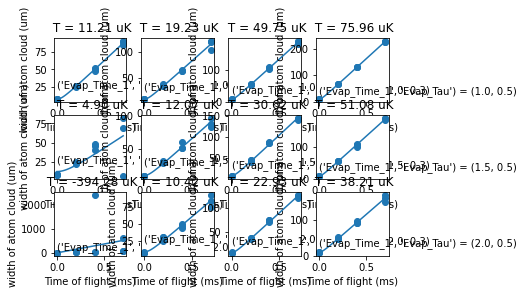

In [37]:
df2 = multiVariableThermometry(df, 'Evap_Time_1', 'Evap_Tau', fitXVar='TOF', 
                               # fitYVar='Ywidth',
                                           # atomNum='YatomNumber', sigma1='Ywidth', sigma2='Ywidth', sigma3='Ywidth',
                                           do_plot=1)

	Old side imaging


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


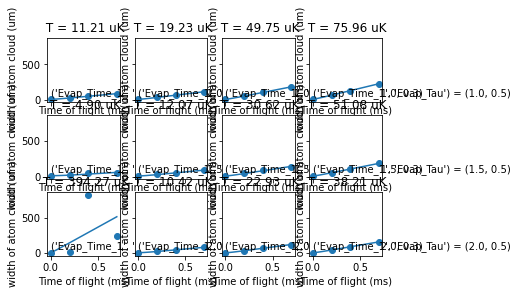

In [10]:
df2 = multiVariableThermometry(df, 'Evap_Time_1', 'Evap_Tau', fitXVar='TOF', 
                               # fitYVar='Ywidth',
                                           # atomNum='YatomNumber', sigma1='Ywidth', sigma2='Ywidth', sigma3='Ywidth',
                                           do_plot=1)

In [87]:
df2

TOF                         0.0       0.05        0.1         0.2         0.3  \
Evap_Time_1 Evap_Tau                                                            
1.5         0.4       15.138738  52.502728  90.150173  168.080263  246.876682   
            0.5       15.143117  51.300463  90.626473  172.799962         NaN   
2.0         0.4       15.263726  50.842254  88.776823  166.088118         NaN   
            0.5       15.250591  50.917766  90.522566  165.493234         NaN   
2.5         0.4       15.269867  50.701332  88.362977  167.858585         NaN   
            0.5       15.175656  50.998822  90.449267  165.912928         NaN   

TOF                          0.4         0.7     T (K)       PSD  
Evap_Time_1 Evap_Tau                                              
1.5         0.4       328.583947  448.029295  0.000360  0.000377  
            0.5       328.072051  462.490216  0.000363  0.000369  
2.0         0.4       327.071493  574.142888  0.000487  0.000237  
            0.5       313.387394  580.091786  0.000485  0.000226  
2.5         0.4       327.319729  497.644950  0.000399  0.000329  
            0.5       328.426413  631.494669  0.000559  0.000198

In [44]:
    a = df2['YatomNumber']
    s1 = df2['Ywidth'] * 2**0.5 / 1e6
    s2 = df2['Ywidth'] / 1e6
    s3 = df2['Ywidth'] / 1e6
    
#     print(PhaseSpaceDensity(a, s1, s2, s3, df1.T))
    PhaseSpaceDensity(a, s1, s2, s3, np.array([100]*6))

Evap_Time_1  Evap_Tau
1.5          0.4         2.573855e-12
             0.5         2.549714e-12
2.0          0.4         2.547991e-12
             0.5         2.415137e-12
2.5          0.4         2.623732e-12
             0.5         2.624189e-12
dtype: float64

In [49]:
s1

Evap_Time_1  Evap_Tau
1.5          0.4         0.000021
             0.5         0.000021
2.0          0.4         0.000022
             0.5         0.000022
2.5          0.4         0.000022
             0.5         0.000021
Name: Ywidth, dtype: float64

In [28]:
df2.reset_index(level='TOF')

TOF     Ycenter     Ywidth    YatomNumber  IterationNum  \
Evap_Time_1 Evap_Tau                                                            
1.5         0.4       0.0  965.989397  15.138738  551448.035524           5.0   
            0.5       0.0  965.561012  15.143117  546750.035055          11.0   
2.0         0.4       0.0  964.864985  15.263726  559539.929522          17.0   
            0.5       0.0  963.165634  15.250591  528996.998356          23.0   
2.5         0.4       0.0  964.620065  15.269867  576868.520142          29.0   
            0.5       0.0  962.880819  15.175656  566355.437214          35.0   

                      IterationCount  wait  AndorROIheight  \
Evap_Time_1 Evap_Tau                                         
1.5         0.4                 36.0   0.0           512.0   
            0.5                 36.0   0.0           512.0   
2.0         0.4                 36.0   0.0           512.0   
            0.5                 36.0   0.0           512.0   
2.5         0.4                 36.0   0.0           512.0   
            0.5                 36.0   0.0           512.0   

                      AndorShortExpDelay_us  LFImg  ...  Evap1_V  tau_evap_s  \
Evap_Time_1 Evap_Tau                                ...                        
1.5         0.4                     2415.44  3.598  ...     0.15         1.0   
            0.5                     2415.44  3.598  ...     0.15         1.0   
2.0         0.4                     2415.44  3.598  ...     0.15         1.0   
            0.5                     2415.44  3.598  ...     0.15         1.0   
2.5         0.4                     2415.44  3.598  ...     0.15         1.0   
            0.5                     2415.44  3.598  ...     0.15         1.0   

                      Evap_2_V  ODT_Position  ODT_Misalign  MedB_Hold  \
Evap_Time_1 Evap_Tau                                                    
1.5         0.4            0.1        1900.0         -18.0       14.0   
            0.5            0.1        1900.0         -18.0       14.0   
2.0         0.4            0.1        1900.0         -18.0       14.0   
            0.5            0.1        1900.0         -18.0       14.0   
2.5         0.4            0.1        1900.0         -18.0       14.0   
            0.5            0.1        1900.0         -18.0       14.0   

                      ImgWaveplate  Evap_Time_2   eta   etaPrime  
Evap_Time_1 Evap_Tau                                              
1.5         0.4              310.0        500.0  10.0  10.833333  
            0.5              310.0        500.0  10.0  10.833333  
2.0         0.4              310.0        500.0  10.0  10.833333  
            0.5              310.0        500.0  10.0  10.833333  
2.5         0.4              310.0        500.0  10.0  10.833333  
            0.5              310.0        500.0  10.0  10.833333  

[6 rows x 57 columns]

In [79]:
df2.T

Evap_Time_1         1.5                     2.0                     2.5  \
Evap_Tau            0.4         0.5         0.4         0.5         0.4   
TOF                                                                       
0.0           15.138738   15.143117   15.263726   15.250591   15.269867   
0.05          52.502728   51.300463   50.842254   50.917766   50.701332   
0.1           90.150173   90.626473   88.776823   90.522566   88.362977   
0.2          168.080263  172.799962  166.088118  165.493234  167.858585   
0.3          246.876682         NaN         NaN         NaN         NaN   
0.4          328.583947  328.072051  327.071493  313.387394  327.319729   
0.7          448.029295  462.490216  574.142888  580.091786  497.644950   
T (K)          0.000360    0.000363    0.000487    0.000485    0.000399   

Evap_Time_1              
Evap_Tau            0.5  
TOF                      
0.0           15.175656  
0.05          50.998822  
0.1           90.449267  
0.2          165.912928  
0.3                 NaN  
0.4          328.426413  
0.7          631.494669  
T (K)          0.000559

In [23]:
constants.h**3 / (2 * np.pi * 9.9883414e-27 * constants.k * T)**1.5

Ycenter     Ywidth    YatomNumber  IterationNum  \
Evap_Time_1 Evap_Tau TOF                                                       
1.5         0.4      0.0  965.989397  15.138738  551448.035524           5.0   
            0.5      0.0  965.561012  15.143117  546750.035055          11.0   
2.0         0.4      0.0  964.864985  15.263726  559539.929522          17.0   
            0.5      0.0  963.165634  15.250591  528996.998356          23.0   
2.5         0.4      0.0  964.620065  15.269867  576868.520142          29.0   
            0.5      0.0  962.880819  15.175656  566355.437214          35.0   

                          IterationCount  wait  AndorROIheight  \
Evap_Time_1 Evap_Tau TOF                                         
1.5         0.4      0.0            36.0   0.0           512.0   
            0.5      0.0            36.0   0.0           512.0   
2.0         0.4      0.0            36.0   0.0           512.0   
            0.5      0.0            36.0   0.0           512.0   
2.5         0.4      0.0            36.0   0.0           512.0   
            0.5      0.0            36.0   0.0           512.0   

                          AndorShortExpDelay_us  LFImg  LF_AOM_freq  ...  \
Evap_Time_1 Evap_Tau TOF                                             ...   
1.5         0.4      0.0                2415.44  3.598        226.0  ...   
            0.5      0.0                2415.44  3.598        226.0  ...   
2.0         0.4      0.0                2415.44  3.598        226.0  ...   
            0.5      0.0                2415.44  3.598        226.0  ...   
2.5         0.4      0.0                2415.44  3.598        226.0  ...   
            0.5      0.0                2415.44  3.598        226.0  ...   

                          Evap1_V  tau_evap_s  Evap_2_V  ODT_Position  \
Evap_Time_1 Evap_Tau TOF                                                
1.5         0.4      0.0     0.15         1.0       0.1        1900.0   
            0.5      0.0     0.15         1.0       0.1        1900.0   
2.0         0.4      0.0     0.15         1.0       0.1        1900.0   
            0.5      0.0     0.15         1.0       0.1        1900.0   
2.5         0.4      0.0     0.15         1.0       0.1        1900.0   
            0.5      0.0     0.15         1.0       0.1        1900.0   

                          ODT_Misalign  MedB_Hold  ImgWaveplate  Evap_Time_2  \
Evap_Time_1 Evap_Tau TOF                                                       
1.5         0.4      0.0         -18.0       14.0         310.0        500.0   
            0.5      0.0         -18.0       14.0         310.0        500.0   
2.0         0.4      0.0         -18.0       14.0         310.0        500.0   
            0.5      0.0         -18.0       14.0         310.0        500.0   
2.5         0.4      0.0         -18.0       14.0         310.0        500.0   
            0.5      0.0         -18.0       14.0         310.0        500.0   

                           eta   etaPrime  
Evap_Time_1 Evap_Tau TOF                   
1.5         0.4      0.0  10.0  10.833333  
            0.5      0.0  10.0  10.833333  
2.0         0.4      0.0  10.0  10.833333  
            0.5      0.0  10.0  10.833333  
2.5         0.4      0.0  10.0  10.833333  
            0.5      0.0  10.0  10.833333  

[6 rows x 56 columns]

In [14]:
df.groupby(['Evap_Time_1', 'Evap_Tau', 'TOF']).mean()

Unnamed: 0  IterationNum  IterationCount  wait  \
Evap_Time_1 Evap_Tau TOF                                                   
1.0         0.05     0.0        81.0          81.0           144.0   0.0   
                     0.2        83.0          83.0           144.0   0.0   
                     0.4        82.0          82.0           144.0   0.0   
                     0.7        80.0          80.0           144.0   0.0   
            0.10     0.0        89.0          89.0           144.0   0.0   
                     0.2        91.0          91.0           144.0   0.0   
                     0.4        90.0          90.0           144.0   0.0   
                     0.7        88.0          88.0           144.0   0.0   
            0.30     0.0        93.0          93.0           144.0   0.0   
                     0.2        95.0          95.0           144.0   0.0   
                     0.4        94.0          94.0           144.0   0.0   
                     0.7        92.0          92.0           144.0   0.0   
            0.50     0.0        85.0          85.0           144.0   0.0   
                     0.2        87.0          87.0           144.0   0.0   
                     0.4        86.0          86.0           144.0   0.0   
                     0.7        84.0          84.0           144.0   0.0   
1.5         0.05     0.0        49.0          49.0           144.0   0.0   
                     0.2        51.0          51.0           144.0   0.0   
                     0.4        50.0          50.0           144.0   0.0   
                     0.7        48.0          48.0           144.0   0.0   
            0.10     0.0        57.0          57.0           144.0   0.0   
                     0.2        59.0          59.0           144.0   0.0   
                     0.4        58.0          58.0           144.0   0.0   
                     0.7        56.0          56.0           144.0   0.0   
            0.30     0.0        61.0          61.0           144.0   0.0   
                     0.2        63.0          63.0           144.0   0.0   
                     0.4        62.0          62.0           144.0   0.0   
                     0.7        60.0          60.0           144.0   0.0   
            0.50     0.0        53.0          53.0           144.0   0.0   
                     0.2        55.0          55.0           144.0   0.0   
                     0.4        54.0          54.0           144.0   0.0   
                     0.7        52.0          52.0           144.0   0.0   
2.0         0.05     0.0        65.0          65.0           144.0   0.0   
                     0.2        67.0          67.0           144.0   0.0   
                     0.4        66.0          66.0           144.0   0.0   
                     0.7        64.0          64.0           144.0   0.0   
            0.10     0.0        73.0          73.0           144.0   0.0   
                     0.2        75.0          75.0           144.0   0.0   
                     0.4        74.0          74.0           144.0   0.0   
                     0.7        72.0          72.0           144.0   0.0   
            0.30     0.0        77.0          77.0           144.0   0.0   
                     0.2        79.0          79.0           144.0   0.0   
                     0.4        78.0          78.0           144.0   0.0   
                     0.7        76.0          76.0           144.0   0.0   
            0.50     0.0        69.0          69.0           144.0   0.0   
                     0.2        71.0          71.0           144.0   0.0   
                     0.4        70.0          70.0           144.0   0.0   
                     0.7        68.0          68.0           144.0   0.0   

                          AndorROIheight  AndorShortExpDelay_us  LFImg  \
Evap_Time_1 Evap_Tau TOF                                                 
1.0         0.05     0.0           512.0                2415.44  3.598   
   

In [21]:
dfSelect = df[['Evap_Time_1', 'Evap_Tau', 'TOF', 'AtomNumber_yfit', 'width_y']]
dfSelect

,Evap_Time_1,Evap_Tau,TOF,AtomNumber_yfit,width_y
0,1.5,0.05,0.7,114274.625439,69.210846
1,1.5,0.05,0.0,88056.843509,7.754061
2,1.5,0.05,0.4,98714.684534,48.821542
3,1.5,0.05,0.2,81944.527146,25.230770
4,1.5,0.50,0.7,311693.831473,187.363595
...,...,...,...,...,...
139,1.0,0.10,0.2,124948.526168,34.407384
140,1.0,0.30,0.7,171046.917645,187.877678
141,1.0,0.30,0.0,128813.125517,8.487952
142,1.0,0.30,0.4,160346.162117,106.405747


In [30]:
for ii, item in dfSelect.groupby(['Evap_Time_1', 'Evap_Tau']):
    print('=====')
    print(ii)
    print('=====')
    print(item)
    

=====
(1.0, 0.05)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.0, 0.1)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.0, 0.3)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.0, 0.5)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.5, 0.05)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.5, 0.1)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.5, 0.3)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(1.5, 0.5)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(2.0, 0.05)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(2.0, 0.1)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(2.0, 0.3)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
=====
(2.0, 0.5)
=====
[0.7 0.  0.4 0.2 0.7 0.  0.4 0.2 0.7 0.  0.4 0.2]
